# **Deepfake Detection Using CNN**

**Importing all necessary libraries**

In [ ]:
import dlib
import cv2
import os
import json
from PIL import Image, ImageChops, ImageEnhance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras_preprocessing
from keras_preprocessing import image
import shutil


from tensorflow.keras.models import Model

**Mount the drive to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Capturing images from the vidoes. Using the metadata, splitting the images into two labels named "fake" and "real".**

In [ ]:
train_frame_folder = '/content/drive/MyDrive/DATA/dfdc_train_part_05/dfdc_train_part_5'

meta_path = ""

for i in os.listdir(train_frame_folder):
    if i.split(".")[1] == "json":
        meta_path = train_frame_folder + "/" + i

with open(os.path.join(train_frame_folder, meta_path), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('/content/drive/MyDrive/DATA/DeepVideos/test_data/real/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame)
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('/content/drive/MyDrive/DATA/DeepVideos/test_data/fake/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame) 
                    # print(count+1)
                count+=1

**There are showing two ways to preprocess the data before training.** 

One way is to convert the images to grayscale, and store them into csv file. And the another way is using ImageDataGenerator library.

**Gray Scale method**

In [ ]:
input_shape = (28,28, 3)
data_dir = '/content/drive/MyDrive/DATA/DeepVideos'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.jpg')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.jpg')]

X = []
Y = []

for img in real_data:
    image = Image.open(data_dir+'/real/'+img)
    resized_img = image.resize((28,28))
    X.append(img_to_array(resized_img).flatten() / 255.0)
    # X.append(img_to_array(image).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    image = Image.open(data_dir+'/fake/'+img)
    resized_img = image.resize((28,28))
    X.append(img_to_array(resized_img).flatten() / 255.0)
    # X.append(img_to_array(image).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 28, 28, 3)

np.savetxt('/content/drive/MyDrive/DATA/DeepVideos/X.csv', X.reshape(3,-1), delimiter=' ')
np.savetxt('/content/drive/MyDrive/DATA/DeepVideos/y.csv', Y, delimiter=' ')


In [ ]:
X = np.loadtxt("/content/drive/MyDrive/DATA/DeepVideos/X.csv")
X=X.reshape(-1,28,28,3)

Y = np.loadtxt("/content/drive/MyDrive/DATA/DeepVideos/y.csv")

If we use the above method, then we can split our datasets like this way.

In [ ]:
#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, random_state=5)

**Using ImageDataGenerator Library**

In this method, we just have to specify the directory path of our data. Then the library will process the images by itself. In addtion, to get a better accuracy I used ***Image Augmentation*** here, so that our model can testify our test data with less loss including more accuracy.

In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/DATA/DeepVideos/train_data"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

VALIDATION_DIR = "/content/drive/MyDrive/DATA/DeepVideos/test_Data"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(300,300),
	class_mode='binary',
  batch_size= 100
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(300,300),
	class_mode='binary',
  batch_size= 35
)

Found 17879 images belonging to 2 classes.
Found 6333 images belonging to 2 classes.


This method is used to get the label indices after using **ImageDataGenerator**. Here is shown only for training data, similarly we can get for the validation data.

In [ ]:
train_generator.class_indices

{'fake': 0, 'real': 1}

**Another way to split datasets.**

The next cell is not necessary all the time. If we have less data, then we can split our data into two sets like this way. One is for training, and the another is for validation.

In [ ]:
root_dir = '/content/drive/MyDrive/DATA/DeepVideos/Data/'
classes_dir = ['fake', 'real']

test_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)

    src = root_dir + cls

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print("*****************************")
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))
    print("*****************************")


    for name in train_FileNames:
        for i in classes_dir:
            shutil.copy(name, root_dir +'train/' + i)

    for name in test_FileNames:
        for i in classes_dir:
            shutil.copy(name, root_dir +'test/' + i)
    print("Copying Done!")

**Building the model.**

This model is about the **Convolutional Neural Network** (CNN). Here I used 3 convolutional layers with 3 maxpooling2D layers. Then we flatten the outputs coming from the CNN layers, and feed them into the **Deep Neural Network** (DNN) layers. Our model is working as **Binary Classification** model.

In [ ]:
model1 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)              

Now, compiled the model.

In [ ]:
model1.compile(loss='binary_crossentropy',
              optimizer = "adam",
              metrics=['accuracy'])

In this cell, the model will be trained, and will be saved to the drive directory where I want to save..

In [ ]:
#Currently not used
# early_stopping = EarlyStopping(monitor='val_loss',
#                                min_delta=0,
#                                patience=2,
#                                verbose=0, mode='auto')
EPOCHS = 5
# BATCH_SIZE = 300
history = model1.fit(train_generator, epochs = 10, steps_per_epoch=10, validation_data= validation_generator, validation_steps=2, verbose = 1)

model1.save('/content/drive/MyDrive/DATA/DeepVideos/deepfake-detection-model.h5')

Epoch 1/10
10/10 [==============================] - 527s 53s/step - loss: 0.6936 - accuracy: 0.5130 - val_loss: 0.6951 - val_accuracy: 0.4750
Epoch 2/10
10/10 [==============================] - 512s 52s/step - loss: 0.6979 - accuracy: 0.5180 - val_loss: 0.7012 - val_accuracy: 0.4500
Epoch 3/10
10/10 [==============================] - 506s 51s/step - loss: 0.6942 - accuracy: 0.5180 - val_loss: 0.6961 - val_accuracy: 0.4500
Epoch 4/10
10/10 [==============================] - 495s 50s/step - loss: 0.6933 - accuracy: 0.4930 - val_loss: 0.6935 - val_accuracy: 0.4250
Epoch 5/10
10/10 [==============================] - 494s 50s/step - loss: 0.6925 - accuracy: 0.5130 - val_loss: 0.7007 - val_accuracy: 0.4500
Epoch 6/10
10/10 [==============================] - 498s 50s/step - loss: 0.6931 - accuracy: 0.5190 - val_loss: 0.6854 - val_accuracy: 0.6250
Epoch 7/10
10/10 [==============================] - 488s 49s/step - loss: 0.6927 - accuracy: 0.5160 - val_loss: 0.6912 - val_accuracy: 0.5250
Epoch 

Now, we will visualize the accuray and the loss value on the training data and the validation data what we got during the training.

ValueError: ignored

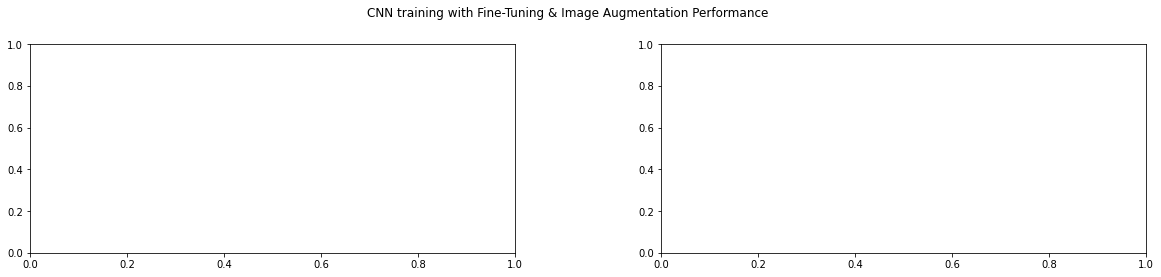

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('CNN training with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


**Loading the saved model**

Now, just to testify we will load our previously saved model, and make prediction on the test data. In addition, after getting the predicted values we will produce a **confusion matrix**.

In [ ]:
model_load = tf.keras.models.load_model("/content/drive/MyDrive/DATA/DeepVideos/deepfake-detection-model.h5")

True positive =  5823
False positive =  0
False negative =  510
True negative =  0




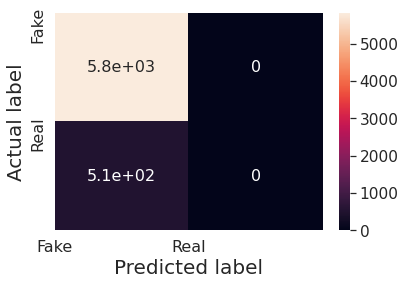

In [23]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()


imag_pred = []
y = []

for fn in os.listdir("/content/drive/MyDrive/DATA/DeepVideos/test_Data"):
  # predicting images
  for i in os.listdir("/content/drive/MyDrive/DATA/DeepVideos/test_Data/" + str(fn)):
    if fn == "fake":
      y.append(0)
    elif fn == "real":
      y.append(1)
    path = "/content/drive/MyDrive/DATA/DeepVideos/test_Data/" + str(fn) + "/" + str(i)
    img = load_img(path, target_size=(300,300))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    
    imag_pred.append(round(model.predict(images)[0][0]))

    
print_confusion_matrix(y, imag_pred)

In [ ]:
import tensorflow as tf

# Transfer Learning

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
train_dir = "/content/drive/MyDrive/DATA/DeepVideos/train_data"
validation_dir = "/content/drive/MyDrive/DATA/DeepVideos/test_Data"

In [ ]:
BATCH_SIZE = 100
IMG_SIZE = (128,128)

train_dataset = image_dataset_from_directory(train_dir,                                         
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 100000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 20000 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 20)
validation_dataset = validation_dataset.skip(val_batches // 20)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 190
Number of test batches: 10


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

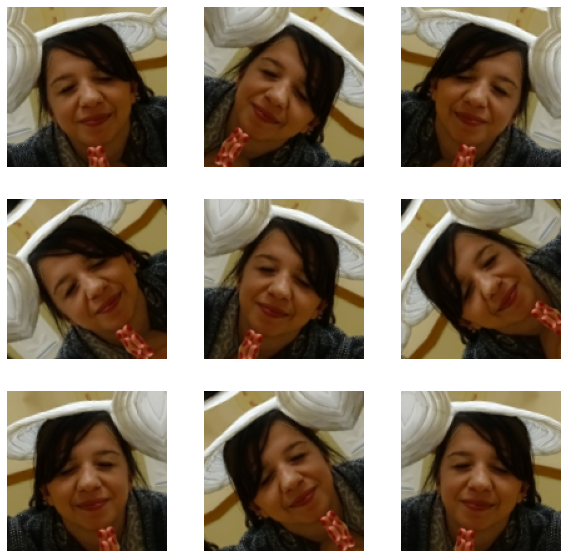

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(100, 4, 4, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(100, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(100, 1)


In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

44/44 [==============================] - 1912s 35s/step - loss: 0.5626 - accuracy: 0.8655


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.56
initial accuracy: 0.87


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    steps_per_epoch=10,
                    validation_steps=2,
                    callbacks=[early_stopping])


model.save('/content/drive/MyDrive/DATA/DeepVideos/deepfake-detection-model_transfer_lr.h5')

Epoch 1/10
10/10 [==============================] - 10s 538ms/step - loss: 0.7687 - accuracy: 0.5800 - val_loss: 0.6400 - val_accuracy: 0.6000
Epoch 2/10
10/10 [==============================] - 205s 23s/step - loss: 0.7543 - accuracy: 0.5750 - val_loss: 0.6813 - val_accuracy: 0.5450
Epoch 3/10
10/10 [==============================] - 255s 26s/step - loss: 0.7887 - accuracy: 0.5590 - val_loss: 0.6346 - val_accuracy: 0.5750
Epoch 4/10
10/10 [==============================] - 254s 26s/step - loss: 0.7460 - accuracy: 0.5880 - val_loss: 0.7005 - val_accuracy: 0.5150
Epoch 5/10
10/10 [==============================] - 253s 26s/step - loss: 0.7072 - accuracy: 0.6110 - val_loss: 0.6476 - val_accuracy: 0.5700


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


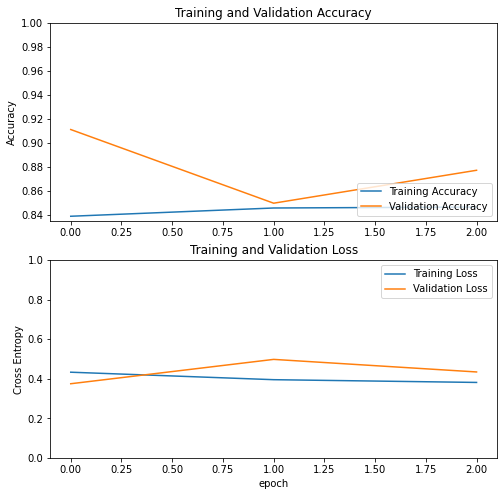

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
a = tf.keras.models.load_model("/content/drive/MyDrive/DATA/DeepVideos/deepfake-detection-model_transfer_lr.h5")

In [ ]:
def video_process(file_path):
    vidcap = cv2.VideoCapture(file_path)
    frameRate = vidcap.get(5)

    count = 0
    while vidcap.isOpened():
        frameId = vidcap.get(1)
        success, image = vidcap.read()

        if success != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            cv2.imwrite("img_data/frame%d.jpg" %
                        count, image)     # save frame as JPEG file
            # print('Read a new frame: ', success)
            count += 1

In [ ]:
d = "/content/drive/MyDrive/DATA/DeepVideos/test_Data/real/"+str(os.listdir("/content/drive/MyDrive/DATA/DeepVideos/test_Data/real")[0])

img = image.load_img(d, target_size=(160,160))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])

a.predict(images)[0][0]

-1.5879331

In [ ]:
round(-1.5879331)

-2

# New CNN model

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
"""
    Propsoed CNN architecture.
    
"""

model = Sequential()

# Pamameters Initialization
input_shape = (300,300,3)
activation = 'relu'
padding = 'same'
droprate = 0.5
epsilon=0.001

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))


model.add(Conv2D(filters=32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=128, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=256, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=512, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dropout(0.5))
          
#model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dropout(droprate))
model.add(Dense(1, activation='sigmoid'))

model.summary() # Summary of the architecture

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 300, 300, 3)       12        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 150, 150, 16)      0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 150, 16)      64        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 75, 32)       

In [19]:
# Parameters Initialization


opt = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                min_delta=0,
                                patience=2,
                                verbose=0, mode='auto')

train_steps = 10
valid_steps = 3
history = model.fit_generator(
    train_generator,
    epochs=10,
    steps_per_epoch = train_steps,
    validation_data = train_generator,
    validation_steps = valid_steps,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 342s 31s/step - loss: 0.5195 - accuracy: 0.7671 - val_loss: 0.4960 - val_accuracy: 0.8067
Epoch 2/10
10/10 [==============================] - 337s 35s/step - loss: 0.4350 - accuracy: 0.8350 - val_loss: 0.4161 - val_accuracy: 0.8567
Epoch 3/10
10/10 [==============================] - 304s 31s/step - loss: 0.4698 - accuracy: 0.8040 - val_loss: 0.4087 - val_accuracy: 0.8600
Epoch 4/10
10/10 [==============================] - 281s 29s/step - loss: 0.4387 - accuracy: 0.8310 - val_loss: 0.4495 - val_accuracy: 0.8333
Epoch 5/10
10/10 [==============================] - 256s 26s/step - loss: 0.4320 - accuracy: 0.8230 - val_loss: 0.3978 - val_accuracy: 0.8733
Epoch 6/10
10/10 [==============================] - 251s 26s/step - loss: 0.4328 - accuracy: 0.8330 - val_loss: 0.3933 - val_accuracy: 0.8733
Epoch 7/10
10/10 [==============================] - 229s 24s/step - loss: 0.3928 - accuracy: 0.8300 - val_loss: 0.4200 - val_accuracy: 0.8600
Epoch 

In [21]:
model.save("new_Cnn.h5")

In [ ]:
d = "/content/drive/MyDrive/DATA/DeepVideos/test_Data/fake/"+str(os.listdir("/content/drive/MyDrive/DATA/DeepVideos/test_Data/fake")[60])

img = image.load_img(d, target_size=(32,32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])

model.predict(images)

array([[0.14247634]], dtype=float32)

In [ ]:
len(os.listdir("/content/drive/MyDrive/DATA/140K_data/real_vs_fake/real-vs-fake/train/real"))

50000